In [5]:
import sys
sys.path.append("..")

from diffusion.gbm_process import simulate_gbm, simulated_gbm_pointwise
from calibration.gbm import calibrate_gbm
from backtesting.backtesting import backtest_gbm_i, backtest_gbm
import QuantLib as ql
import numpy as np
import pandas as pd
from datetime import datetime
import json
import matplotlib.pyplot as plt
%config IPCompleter.greedy = True

In [178]:
# Setting evaluation date
today = ql.Date(7,3,2021)
no_of_timestep = 100
N=1000
maturity = 20

daily = [today + ql.Period(i,ql.Days) for i in range(0,365 * 3)]
weekly = [daily[-1] + ql.Period(i,ql.Weeks) for i in range(0,25)]
monthly = [weekly[-1] + ql.Period(i,ql.Weeks) for i in range(0,12)]
yearly = [monthly[-1] + ql.Period(i,ql.Years) for i in range(0,20)]
date_grid = [*daily, *weekly, *monthly, *yearly]

time_grid = np.vectorize(lambda x: ql.ActualActual().yearFraction(today, x))(date_grid)
dt = time_grid[1:] - time_grid[:-1]
maturity = time_grid[-1]
maturity_date = date_grid[-1]

In [179]:
df = simulate_gbm(100, daily, 20, {'mu':0.3, 'sigma':0.1})

In [180]:
mu_list = []
sigma_list = []

for i in range(2, len(df)):
    mu_list.append([values['mu'] for values in calibrate_gbm(df.iloc[0:i], 1/365).values() ])
    sigma_list.append([values['sigma'] for values in calibrate_gbm(df.iloc[0:i], 1/365).values() ])
    

In [190]:
import matplotlib as mpl
mpl.rc("savefig", dpi=200)
%config InlineBackend.figure_format = 'svg'


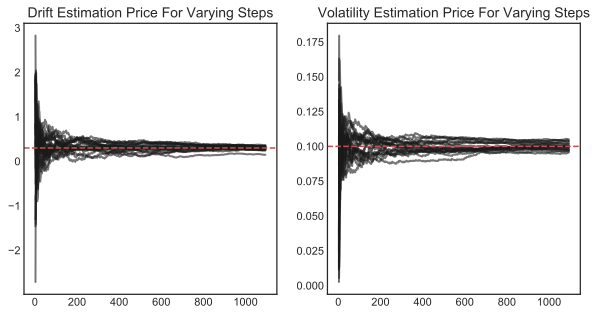

In [192]:
plt.style.use('seaborn-white')
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].plot(range(2, len(df)), mu_list, "k", label="Estimated drift", lw=2, alpha=0.6)
axes[0].axhline(y=0.3, color='r', linestyle='--', label='Original Drift')
axes[0].set_title("Drift Estimation Price For Varying Steps", size=14)
# axes[0].legend(fontsize=18)

axes[1].plot(range(2, len(df)), sigma_list, "k", label="Estimated Volatility", lw=2, alpha=0.6)
axes[1].axhline(y=0.1, color='r', linestyle='--', label='Original Volatility')
axes[1].set_title("Volatility Estimation Price For Varying Steps", size=14)
plt.savefig('C:/Users/eyyup/Desktop/DTU/master thesis/plots/gbm_stability_calibration2.png')
# axes[1].legend(fontsize=18)

In [ ]:
calibration_config_path = 'C:/Users/eyyup/Desktop/packages/masters_thesis/static/settings/calibration_settings.json'
backtest_config_path = 'C:/Users/eyyup/Desktop/packages/masters_thesis/static/settings/backtesting_configuration.json'

#### Critical Values(generating scenarios from the original model)


In [54]:
from backtesting.critical_values import generate_critical_values_gbm
from os.path import join
import os

with open(backtest_config_path) as f:
    dict_bt = json.load(f)
with open(calibration_config_path) as f:
    dict_cal = json.load(f)

df = pd.read_csv(join('C:/Users/eyyup/Desktop/packages/masters_thesis/static/data/', 'data_from_mars.csv'))
df = df.pivot_table(index='EOD_DATE', values='PRICE', columns=['ISIN'])
df.index = pd.to_datetime(df.index)
df = df[[key for key in df.isna().sum().to_frame().sort_values(0).to_dict()[0]]]
df = df.iloc[:, :30].dropna()

idx = pd.date_range('2010-02-03', '2021-03-10', freq='D')
df = df.reindex(idx, fill_value=np.nan)
df = df[df.index.weekday == 2].interpolate(method='linear')

equity_name = 'US78378X1072'
for horizon_w in [2, 4, 8, 24, 52]:
    dict_bt['backtesting_horizon_w'] = horizon_w
    critical_path = join('C:/Users/eyyup/Desktop/packages/masters_thesis/static/data/backtesting/', 
                         'critical_values_horizon_%s.csv' % str(horizon_w))
    if exists(critical_path):
        print('%s already exists' % critical_path)
        continue
    df_critical_values = generate_critical_values_gbm(df, 
                                                      equity_name, 
                                                      dict_bt, 
                                                      dict_cal, 
                                                      scenario_amount=200)
    df_critical_values.to_csv(critical_path ,index=False)


..\backtesting\backtesting.py:27: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  initial_value = df_x.ix[bt_beginning_date.to_date()].to_frame().T
..\backtesting\backtesting.py:32: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  realisation_date = pd.Timestamp((df_x.ix[bt_beginning_date.to_date()].to_frame().T.index +


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104


Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
9
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 0

Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
21
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 

Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
33
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 

Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
45
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 

Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
57
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 

Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
69
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 

Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
81
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 

Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
93
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 

Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
105
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17

Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
117
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17

Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
129
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17

Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
141
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17

Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
153
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17

Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
165
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17

Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
177
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17

Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
189
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17

Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:

Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:

Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:

Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:

Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:

Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:

Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:

Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:

Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:

Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:

Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:

Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:

Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:

Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:

Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:

Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:

Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:

Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:

Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:

Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:

Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:

Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:

Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:

Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:

Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:

Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:

Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:

Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:

Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:

Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:

Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:

Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:

Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:

Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:

Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:

Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:

Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:

Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:

Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:

Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:

Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:

Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:

Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:

Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:

Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:

Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:

Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:

Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:

Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:

Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:00:00 
Data point does not exists for  2021-03-17 00:

In [27]:
import scipy.stats as stats
import pylab 
import pandas as pd
from backtesting.critical_values import generate_critical_values_gbm
from os.path import join
import os
import statsmodels.api as sm

In [22]:
df = pd.read_csv(join('C:/Users/eyyup/Desktop/packages/masters_thesis/static/data/', 'data_from_mars.csv'))
df = df.pivot_table(index='EOD_DATE', values='PRICE', columns=['ISIN'])
df.index = pd.to_datetime(df.index)
df = df[[key for key in df.isna().sum().to_frame().sort_values(0).to_dict()[0]]]
df = df.iloc[:, :30].dropna()

In [23]:
log_returns = np.log(df['US78378X1072']) - np.log(df['US78378X1072'].shift(1))

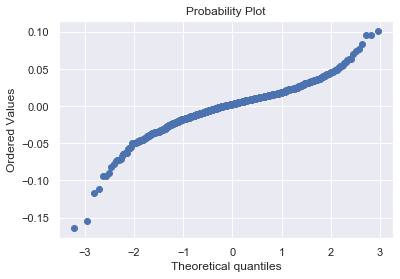

In [33]:
stats.probplot(log_returns, dist="norm", plot=pylab)
pylab.show()